In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/Users/donavanrooi/Desktop/Data Science/Datasets/diabetes_012_health_indicators_BRFSS2015.csv')

In [4]:
import seaborn as sns

In [5]:
# Separate features (X) and target variable (y)
# here the least informative features are already removed, they were identified using LASSO
X = df.drop(['Diabetes_012', "Fruits", "Veggies", "PhysActivity", "AnyHealthcare", "NoDocbcCost", "MentHlth", "PhysHlth", "Smoker"], axis=1)
y = df['Diabetes_012']

In [7]:
X.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke',
       'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'GenHlth', 'DiffWalk',
       'Sex', 'Age', 'Education', 'Income'],
      dtype='object')

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

#The dataset is split into training and testing sets, with 20% of the data reserved for testing and 80% for training, 
# while random_state=42 ensures the split is reproducible each time the code is executed.

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# Scale numeric features only, this is also called z-standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This process ensures that both the training and test datasets are standardized, meaning the features across both sets have similar scales. Each feature is adjusted so that its values are centered around zero and scaled to have a consistent spread, 
# resulting in a zero mean and a variance of one.

In [19]:
from sklearn.utils.class_weight import compute_sample_weight

In [20]:
# Calculate sample weights, inversely proportional to class frequencies
sample_weights = compute_sample_weight(
    class_weight='balanced', # 'balanced' automatically computes inverse weights
    y=y_train
)

In [21]:
import xgboost as xgb

In [22]:
# changed the objective= to multi:softprob
reg = xgb.XGBClassifier(base_score=0.5, booster='gbtree',    
                       n_estimators=756,
                       early_stopping_rounds=50,
                       objective='multi:softprob',
                       max_depth=8,
                       learning_rate=0.113,
                       min_child_weight=3,
                       reg_alpha=0.199,
                       colsample_bytree=0.99,
                       eval_metric='mlogloss')

reg.fit(X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
        sample_weight=sample_weights,
        verbose=100)

[0]	validation_0-mlogloss:1.05779	validation_1-mlogloss:1.05878
[100]	validation_0-mlogloss:0.73797	validation_1-mlogloss:0.78036
[200]	validation_0-mlogloss:0.65602	validation_1-mlogloss:0.73143
[300]	validation_0-mlogloss:0.59534	validation_1-mlogloss:0.69803


KeyboardInterrupt: 

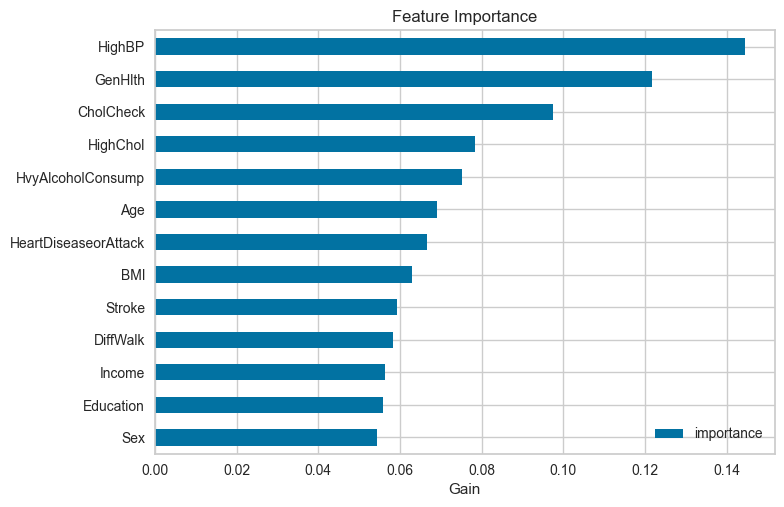

In [14]:
import matplotlib.pyplot as plt

feature_names = X.columns

fi = pd.DataFrame(data=reg.feature_importances_, index=feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Gain')
plt.show()

# Here I added the feature names to be on the y axis for brevity
# Gain measures a feature's relative importance by calculating the average improvement (loss reduction) 
# it brings to the model when used for splitting nodes in the decision trees, 
# representing how much more accurate those branches become compared to before the split

In [15]:
# As this is a classification problem we use these metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [16]:
# compute performance on test set
y_pred = reg.predict(X_test_scaled)
print(f'accuracy score: {accuracy_score(y_test,y_pred):.2f}')
print(f'precision score: {precision_score(y_test,y_pred,  average="weighted"):.2f}')
print(f'recall score: {recall_score(y_test,y_pred,  average="weighted"):.2f}')
print(f'f1 score: {f1_score(y_test,y_pred,  average="weighted"):.2f}')

accuracy score: 0.68
precision score: 0.83
recall score: 0.68
f1 score: 0.73


In [17]:
from sklearn.metrics import classification_report

# y_test and y_pred_1 are your true and predicted labels
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80     64111
         1.0       0.03      0.14      0.04      1389
         2.0       0.32      0.62      0.42     10604

    accuracy                           0.68     76104
   macro avg       0.43      0.48      0.42     76104
weighted avg       0.83      0.68      0.73     76104



Confusion Matrix Array:
[[44738  6068 13305]
 [  533   193   663]
 [ 2669  1405  6530]]


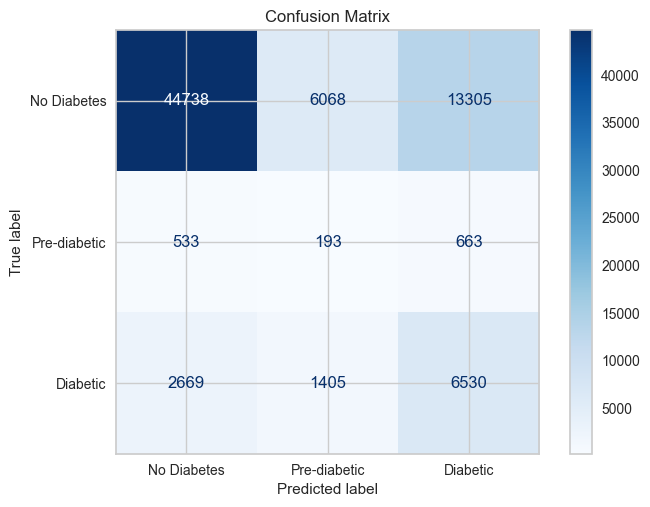

In [18]:
# 1. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix Array:\n{cm}")

# 2. Visualize the confusion matrix with labels
# Use ConfusionMatrixDisplay for an easy-to-read plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Pre-diabetic", "Diabetic"])

# Plot the figure
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# For a multiclass problem (3 targets) with imbalanced data, it is best to plot separate One-vs-Rest (OvR) curves for each class. 
# This allows you to visually confirm that the "middle group" is underperforming compared to the others.